### What is Conditional GAN (cGAN)
GAN with conditional ( label information ) to create exactly image that has specific label


In [0]:
import os
import shutil
from sklearn.utils import shuffle
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, VGG19, InceptionResNetV2, InceptionV3, DenseNet201
from keras.applications.xception import Xception
from keras.callbacks import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import re
from keras.datasets import mnist

from IPython import display

Using TensorFlow backend.


In [0]:
NUM_CLASSES = 10
sample_w, sample_h = 10, 10
random_z_for_generator = np.random.normal(0, 1, (sample_w * sample_h, 100))
z_dim, img_shape = 100, (28,28,1)

iterations = 5000
batch_size = 128
sample_interval = 500

### UTIL

In [0]:
def sample_images(folder, generator, ep, image_grid_rows=sample_w, image_grid_columns=sample_h):                    
    randomLabel_batch = np.arange(sample_w * sample_h) % 10
    randomLabel_batch_onehot = np.array([label2onehot(i) for i in randomLabel_batch])
    noise_with_randomLabel = np.concatenate((random_z_for_generator, randomLabel_batch_onehot),axis=1)
    
    gen_imgs = generator.predict(noise_with_randomLabel, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5


    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(5, 5),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
          # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

#     if not os.path.exists(folder):
#         os.mkdir(folder)
#     img_name = 'image_at_epoch_{}.png'.format(ep+1)
    #   plt.savefig(img_name)
    #   shutil.move(img_name, os.path.join(os.getcwd(), folder))
    
    plt.show()

### Build Generator and Discriminator
Add layer information into Generator 


```
model.add(Dense(7*7*256, input_dim=(z_dim+NUM_CLASSES)))
```

and into Discriminator


```
model.add(Conv2D(32, kernel_size=ker, strides=2, padding='same',input_shape=(img_shape[0], img_shape[1], (img_shape[2] + NUM_CLASSES))))
```





In [0]:
from keras.layers.advanced_activations import LeakyReLU
def build_cgan_generator(img_shape, z_dim, ker=3, useRelu=False):
    model = Sequential()
    
    model.add(Dense(7*7*256, input_dim=(z_dim+NUM_CLASSES)))
    model.add(Reshape((7,7,256)))
    # 7x7x256 -> 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))

    # 14x14x128 -> 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=ker, strides=1, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))

    # 14x14x64 -> 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=ker, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

In [0]:
def build_cgan_discriminator(img_shape, ker=3):
    model = Sequential()

    # 28x28x1 -> 14x14x32
    model.add(Conv2D(32, kernel_size=ker, strides=2, padding='same',input_shape=(img_shape[0], img_shape[1], (img_shape[2] + NUM_CLASSES))))
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32 -> 7x7x64
    model.add(Conv2D(64, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64 -> 3x3x128
    model.add(Conv2D(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

### Combine into CGAN
Build CGAN using


```
model = Model(input=[ ], output=valid)
```


instead of 


```
  model.add(generator)
  model.add(discriminator)
```

because some addition informations are necessary

In [0]:
from keras.layers import merge 
def build_cgan(z_dim, img_shape, generator, discriminator):
    z = Input(shape=(z_dim,))
    y = Input(shape=(NUM_CLASSES,))
    z_y = merge.concatenate([z,y], axis=-1)
    img_10 = Input(shape=(img_shape[0], img_shape[1], NUM_CLASSES))
    
    g_img = generator(z_y)
    img_11 = merge.concatenate([g_img, img_10], axis=3) 
    discriminator.trainable = False
    valid = discriminator(img_11)
    
    model = Model(input=[z, y, img_10], output=valid)
    return model

### Train conditional GAN
More difficult than DCGAN to train.

Generator input : [noise_z, noise_label] (shape = dim + len(label)) instead of [noise_z] only
* noise_label is one-hot vector, created randomly each time train discriminator/generator

Discriminator input: NUM_CLASS x [w, h, 1] images instead of one [w, h, 1] image
* In NUM_CLASS images,  noise_label-th image is white, the others are black

In [0]:
def label2onehot(label):
    onehot = np.zeros(NUM_CLASSES)
    onehot[label] = 1
    return onehot

def label2images(label):
    images = np.zeros((28, 28, NUM_CLASSES))
    images[:,:,label] += 1
    return images

In [0]:
def train_cgan(generator, discriminator, interations, batch_size, sample_interval, model_name=''):
    random_z_for_generator = np.random.normal(0, 1, (batch_size, 100))
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, X_label), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1   # or X_train = (X_train - 127.5 ) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    cgan = build_cgan(z_dim, img_shape, generator, discriminator)
    cgan.compile(loss='binary_crossentropy', optimizer='Adam')

    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        r_imgs = X_train[idx]
        r_labels = X_label[idx]
        r_imgs_10 = np.array([label2images(i) for i in r_labels])
        r_imgs_11 = np.concatenate((r_imgs, r_imgs_10), axis=3)
        
        noise_z = np.random.normal(0, 1, (batch_size, 100))
        noise_y_init = np.random.randint(0, NUM_CLASSES,batch_size)
        noise_y = np.array([label2onehot(i) for i in noise_y_init])
        noise_z_y = np.concatenate((noise_z, noise_y), axis=1)
        
        f_imgs = generator.predict(noise_z_y, verbose=0)
        f_imgs_10 = np.array([label2images(i) for i in noise_y_init])
        f_imgs_11 = np.concatenate((f_imgs, f_imgs_10), axis=3)

        d_loss_real = discriminator.train_on_batch(r_imgs_11, real)
        d_loss_fake = discriminator.train_on_batch(f_imgs_11, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        random_y_int = np.random.randint(0, NUM_CLASSES,batch_size)
        y = np.array([label2onehot(i) for i in random_y_int])
        img_10 = np.array([label2images(i) for i in random_y_int])
        
        g_loss = cgan.train_on_batch([z, y, img_10], real)
        
        
        # show result
        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                      (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            #       display.clear_output(wait=True)
            sample_images(model_name, generator, iteration, 10, 10)

In [0]:
generator = build_cgan_generator(img_shape, z_dim, ker=5, useRelu=True)

discriminator = build_cgan_discriminator(img_shape, ker=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, beta_2=0.9), metrics=['accuracy'])
discriminator.trainable = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("se...)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.716880, acc.: 64.84%] [G loss: 2.300004]


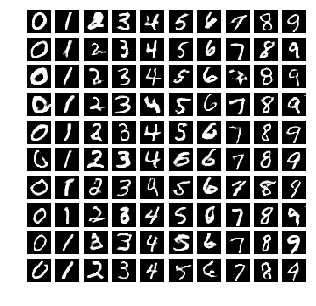

2000 [D loss: 0.189445, acc.: 96.09%] [G loss: 3.467360]


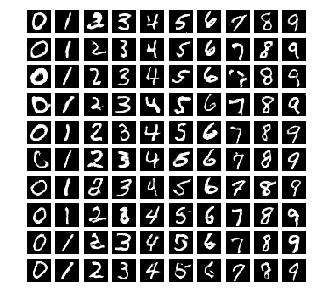

3000 [D loss: 0.103698, acc.: 98.44%] [G loss: 3.093220]


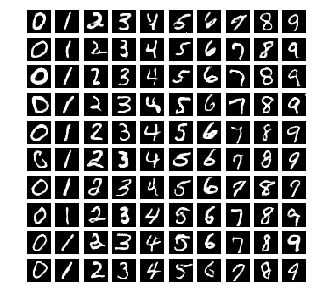

4000 [D loss: 0.296038, acc.: 86.72%] [G loss: 2.379422]


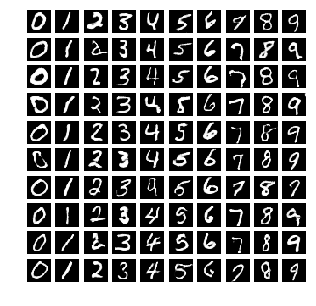

5000 [D loss: 1.322209, acc.: 26.95%] [G loss: 1.199746]


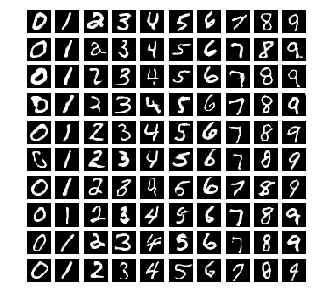

6000 [D loss: 0.108908, acc.: 99.22%] [G loss: 3.757493]


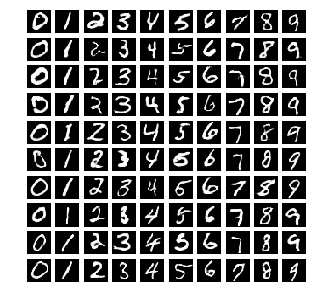

7000 [D loss: 0.156526, acc.: 96.48%] [G loss: 4.021684]


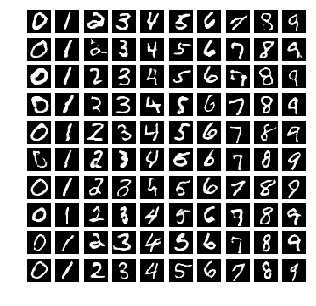

8000 [D loss: 0.789778, acc.: 56.25%] [G loss: 3.221374]


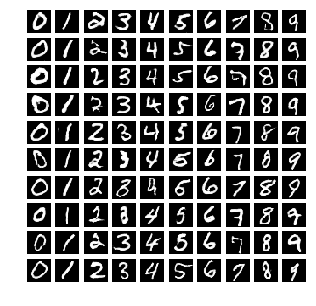

9000 [D loss: 0.562535, acc.: 69.53%] [G loss: 2.192380]


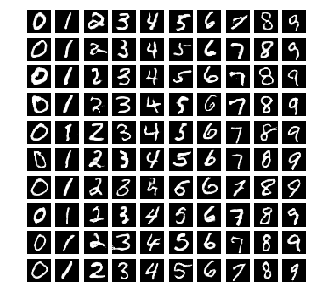

10000 [D loss: 0.206750, acc.: 97.66%] [G loss: 3.922321]


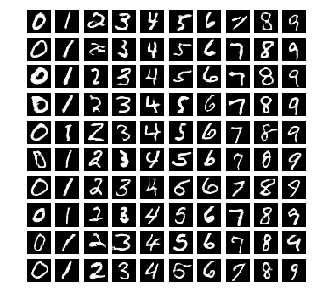

11000 [D loss: 0.438690, acc.: 79.30%] [G loss: 3.585360]


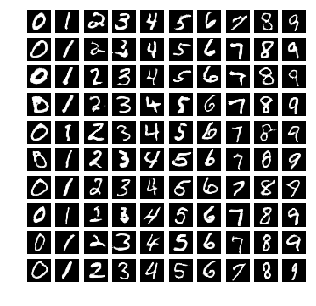

12000 [D loss: 0.061058, acc.: 100.00%] [G loss: 3.786621]


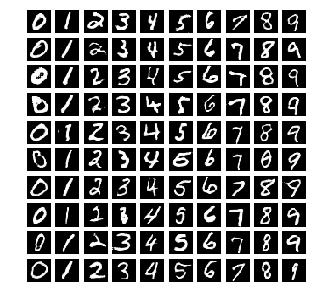

13000 [D loss: 0.041287, acc.: 99.22%] [G loss: 5.987746]


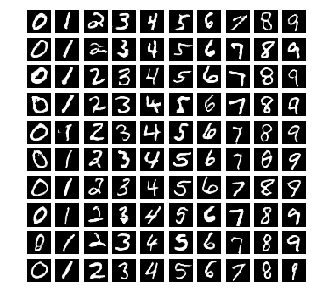

14000 [D loss: 0.252114, acc.: 92.97%] [G loss: 3.522407]


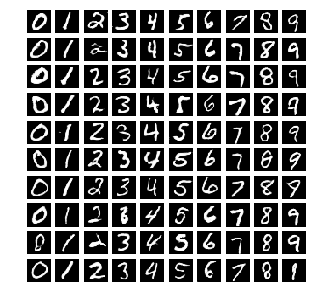

15000 [D loss: 0.174472, acc.: 96.09%] [G loss: 3.121373]


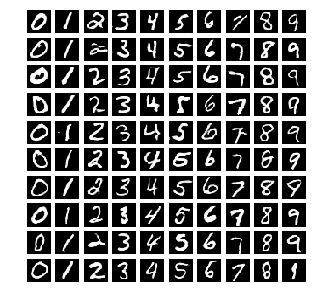

16000 [D loss: 0.085300, acc.: 99.22%] [G loss: 2.485732]


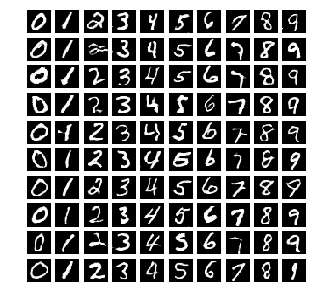

17000 [D loss: 0.925759, acc.: 48.44%] [G loss: 3.154620]


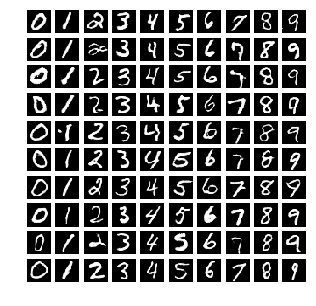

18000 [D loss: 0.262937, acc.: 91.02%] [G loss: 2.746217]


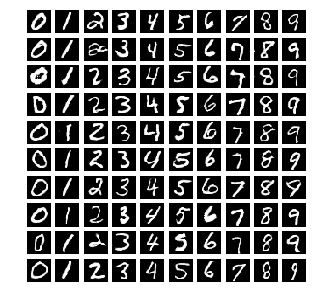

19000 [D loss: 0.471602, acc.: 75.39%] [G loss: 4.691120]


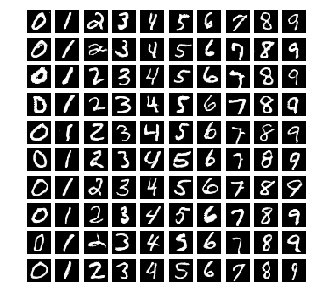

20000 [D loss: 0.322742, acc.: 85.55%] [G loss: 2.892942]


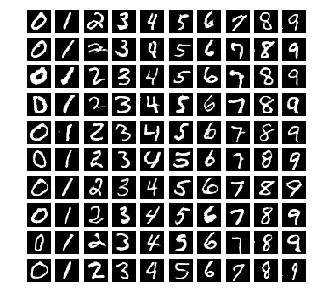

21000 [D loss: 0.562364, acc.: 71.88%] [G loss: 2.416187]


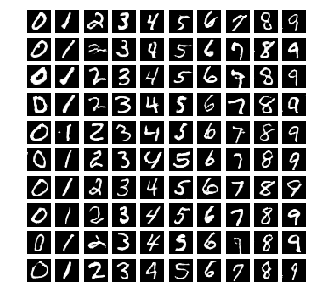

22000 [D loss: 0.206107, acc.: 94.53%] [G loss: 7.088463]


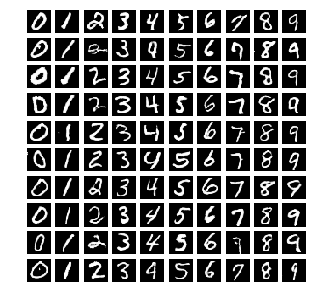

23000 [D loss: 0.067018, acc.: 98.83%] [G loss: 4.829810]


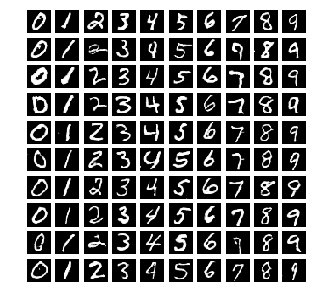

24000 [D loss: 0.106851, acc.: 98.44%] [G loss: 4.934190]


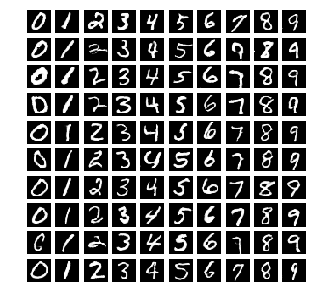

25000 [D loss: 0.108622, acc.: 98.44%] [G loss: 5.545602]


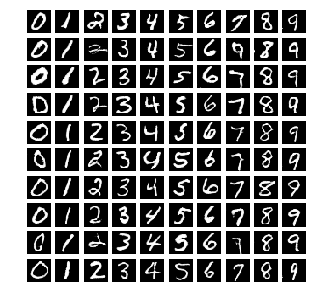

26000 [D loss: 0.675025, acc.: 64.45%] [G loss: 1.617792]


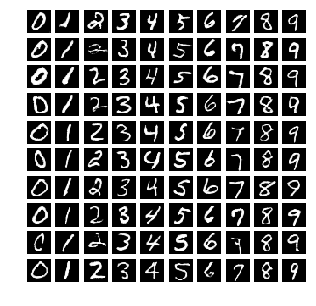

27000 [D loss: 1.173302, acc.: 33.20%] [G loss: 2.491635]


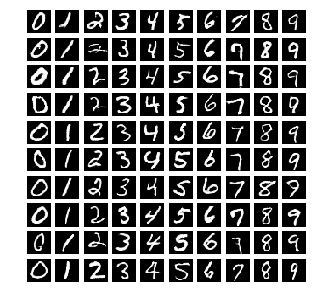

28000 [D loss: 0.076592, acc.: 99.22%] [G loss: 3.588187]


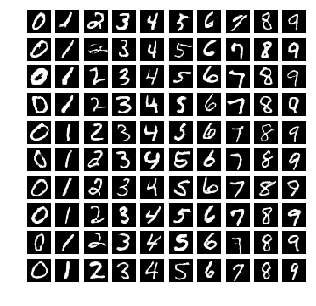

29000 [D loss: 0.227747, acc.: 91.02%] [G loss: 3.546380]


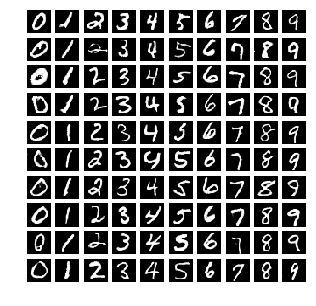

30000 [D loss: 0.037511, acc.: 100.00%] [G loss: 5.199385]


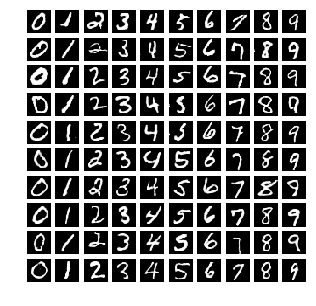

31000 [D loss: 0.025153, acc.: 100.00%] [G loss: 3.459114]


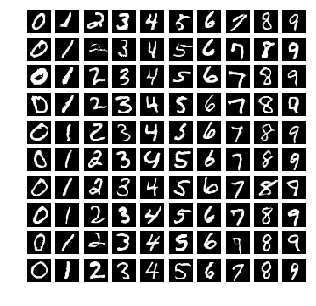

32000 [D loss: 0.217633, acc.: 94.92%] [G loss: 2.022928]


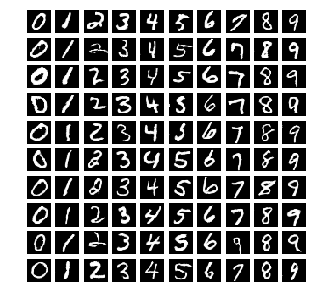

33000 [D loss: 0.279309, acc.: 90.23%] [G loss: 3.540897]


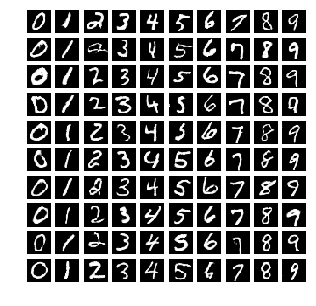

34000 [D loss: 0.139194, acc.: 96.48%] [G loss: 2.863175]


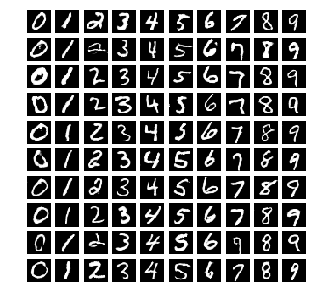

35000 [D loss: 0.170732, acc.: 95.70%] [G loss: 3.906192]


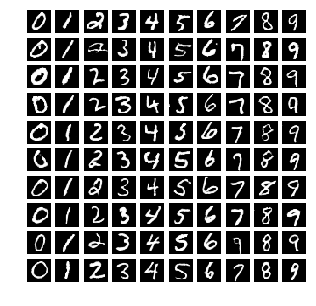

36000 [D loss: 0.253964, acc.: 91.02%] [G loss: 3.321194]


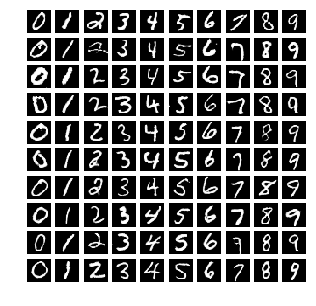

37000 [D loss: 0.202570, acc.: 94.53%] [G loss: 3.543847]


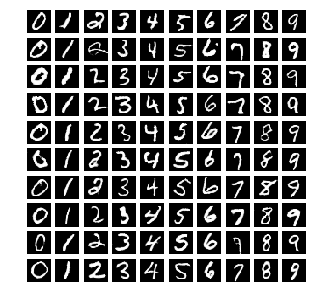

38000 [D loss: 0.271857, acc.: 90.23%] [G loss: 3.848941]


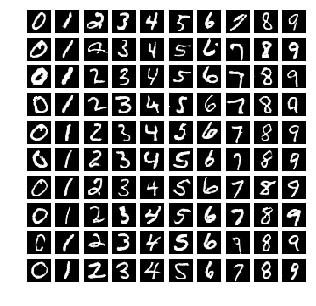

39000 [D loss: 0.126456, acc.: 95.70%] [G loss: 4.369903]


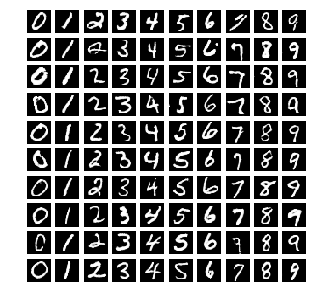

40000 [D loss: 0.130311, acc.: 98.05%] [G loss: 3.703090]


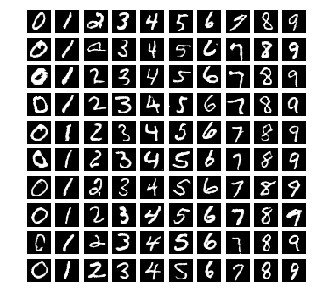

41000 [D loss: 0.141361, acc.: 96.48%] [G loss: 4.904649]


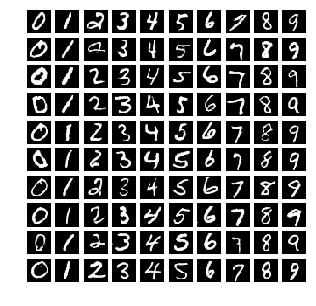

42000 [D loss: 0.061835, acc.: 98.83%] [G loss: 5.966786]


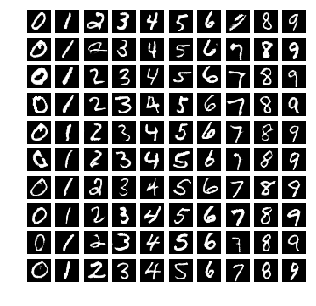

43000 [D loss: 0.244266, acc.: 92.58%] [G loss: 4.010651]


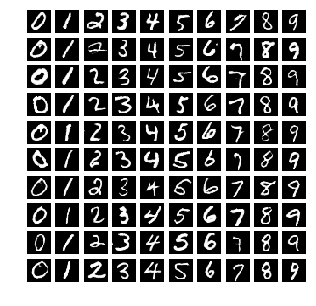

44000 [D loss: 0.405892, acc.: 81.25%] [G loss: 4.721085]


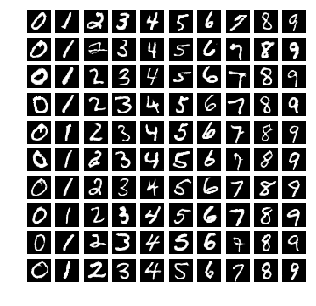

45000 [D loss: 0.289664, acc.: 89.84%] [G loss: 2.729085]


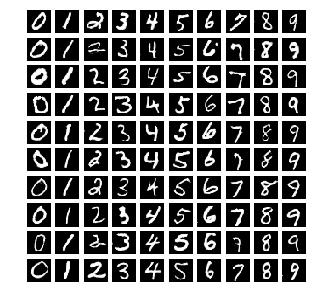

46000 [D loss: 0.391348, acc.: 81.64%] [G loss: 4.633463]


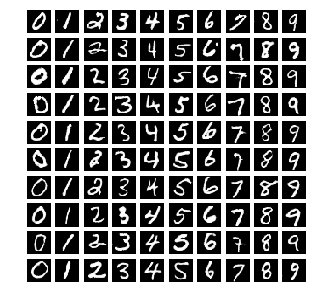

47000 [D loss: 0.328352, acc.: 86.33%] [G loss: 2.839262]


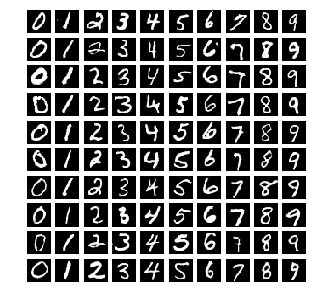

48000 [D loss: 0.140029, acc.: 96.88%] [G loss: 4.263821]


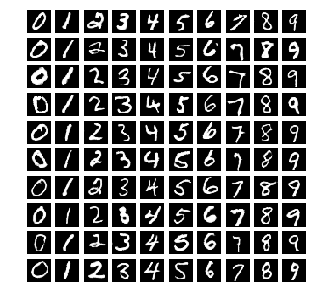

49000 [D loss: 0.283900, acc.: 91.02%] [G loss: 3.174127]


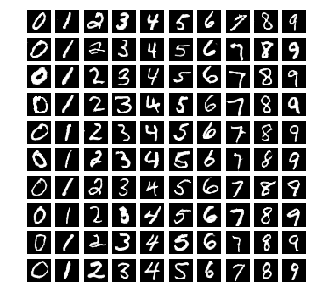

50000 [D loss: 0.641977, acc.: 66.02%] [G loss: 2.661555]


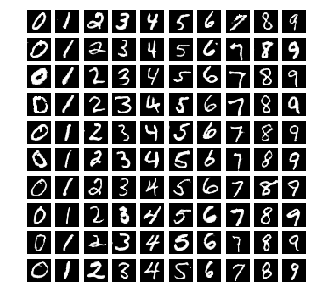

51000 [D loss: 0.391687, acc.: 78.91%] [G loss: 3.559671]


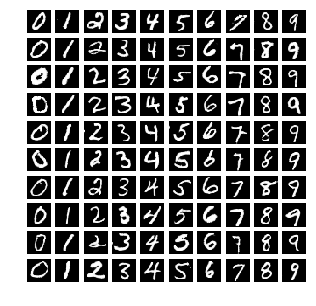

52000 [D loss: 0.207811, acc.: 91.80%] [G loss: 3.288359]


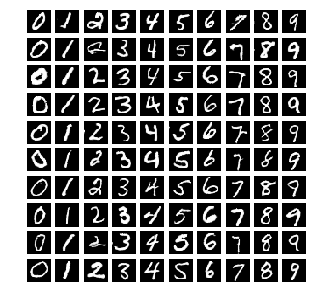

53000 [D loss: 0.052592, acc.: 99.22%] [G loss: 3.519660]


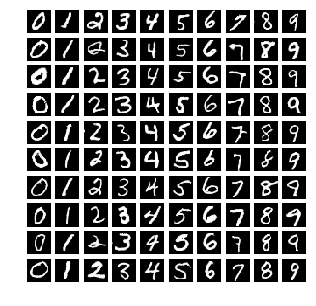

54000 [D loss: 0.070495, acc.: 99.61%] [G loss: 3.702543]


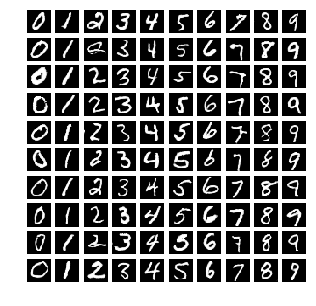

55000 [D loss: 0.135924, acc.: 96.09%] [G loss: 4.557754]


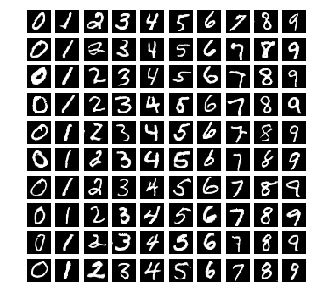

56000 [D loss: 0.100046, acc.: 97.66%] [G loss: 5.720548]


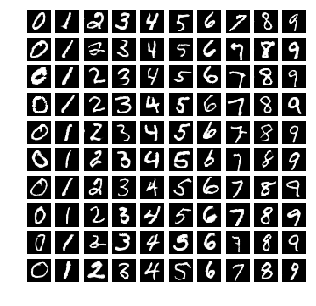

57000 [D loss: 0.364282, acc.: 82.42%] [G loss: 4.055746]


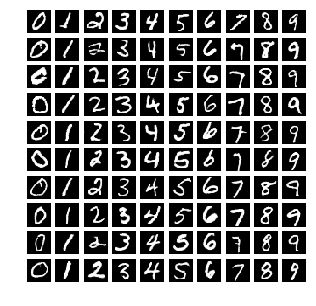

58000 [D loss: 0.063529, acc.: 99.22%] [G loss: 4.098903]


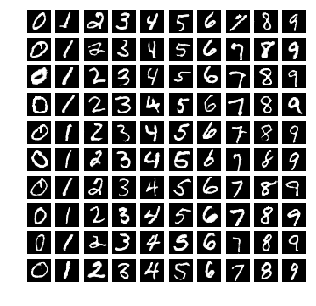

59000 [D loss: 0.311846, acc.: 85.55%] [G loss: 3.630836]


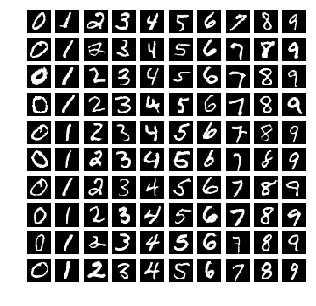

60000 [D loss: 0.074310, acc.: 99.61%] [G loss: 4.816244]


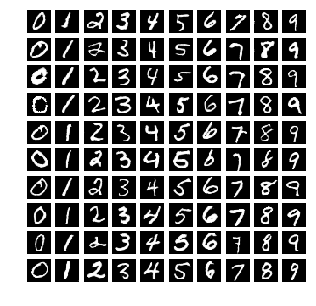

61000 [D loss: 0.325838, acc.: 86.33%] [G loss: 4.337872]


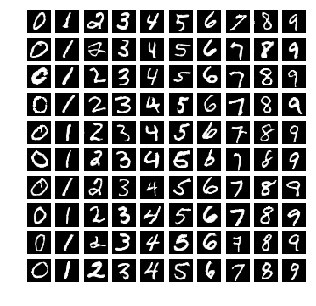

62000 [D loss: 0.035157, acc.: 99.61%] [G loss: 3.069585]


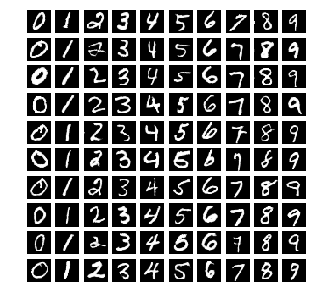

63000 [D loss: 0.139162, acc.: 95.31%] [G loss: 5.503748]


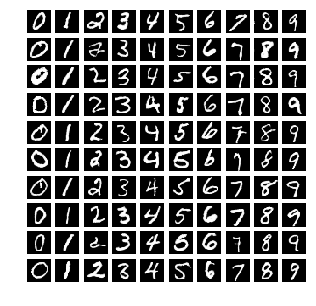

64000 [D loss: 0.129797, acc.: 98.83%] [G loss: 4.272942]


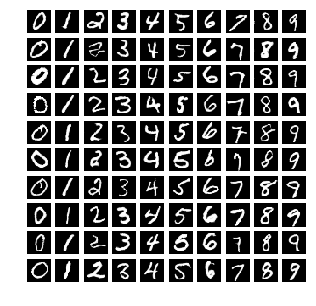

65000 [D loss: 1.183926, acc.: 39.45%] [G loss: 2.147551]


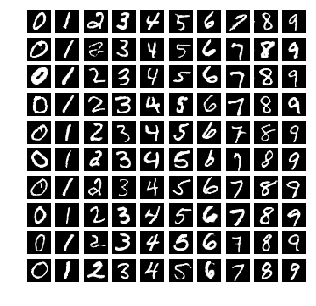

66000 [D loss: 0.127631, acc.: 96.09%] [G loss: 4.907205]


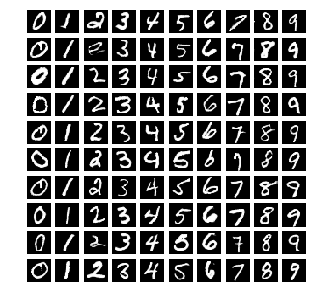

67000 [D loss: 0.136041, acc.: 96.88%] [G loss: 7.037214]


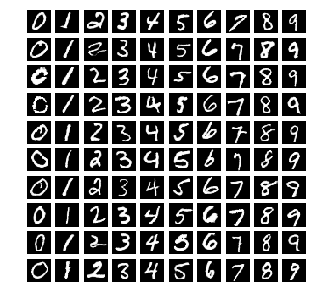

68000 [D loss: 0.173863, acc.: 94.92%] [G loss: 3.956135]


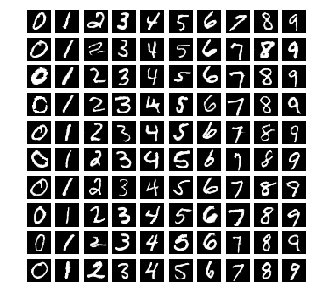

69000 [D loss: 0.163201, acc.: 96.09%] [G loss: 4.691935]


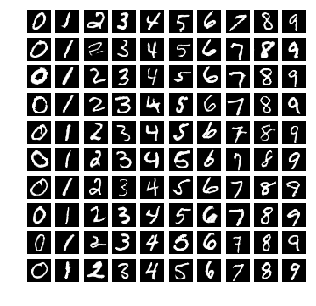

70000 [D loss: 0.175876, acc.: 95.31%] [G loss: 4.960391]


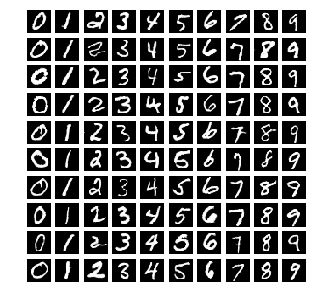

71000 [D loss: 0.038334, acc.: 99.61%] [G loss: 8.336712]


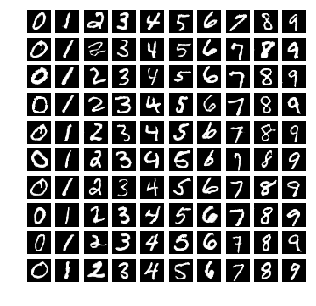

72000 [D loss: 0.055007, acc.: 99.22%] [G loss: 6.860680]


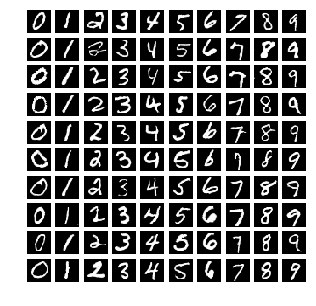

73000 [D loss: 0.146892, acc.: 96.48%] [G loss: 2.395732]


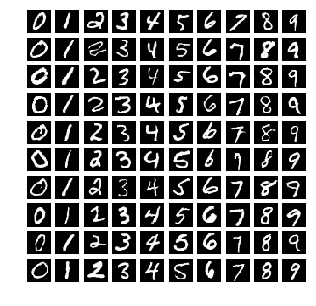

74000 [D loss: 0.262206, acc.: 86.72%] [G loss: 0.906337]


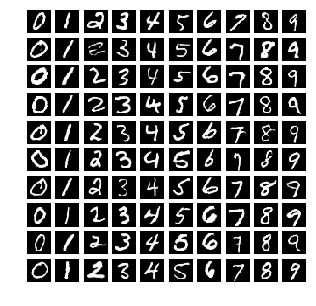

75000 [D loss: 0.062480, acc.: 98.83%] [G loss: 3.569881]


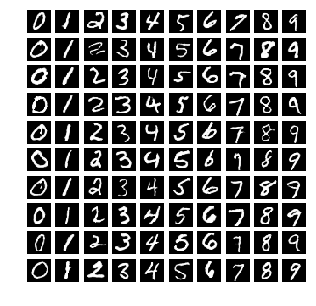

76000 [D loss: 0.044331, acc.: 100.00%] [G loss: 3.747894]


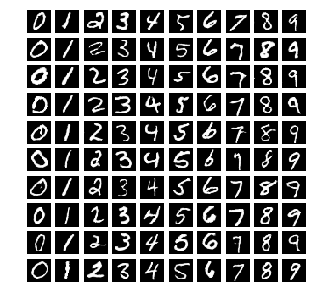

77000 [D loss: 0.083588, acc.: 98.44%] [G loss: 2.560068]


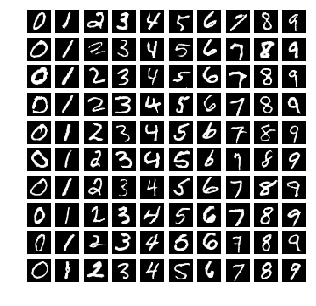

78000 [D loss: 0.935265, acc.: 46.88%] [G loss: 3.205246]


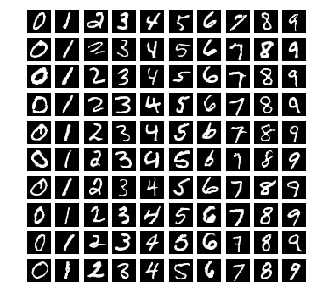

79000 [D loss: 0.106498, acc.: 98.44%] [G loss: 5.219638]


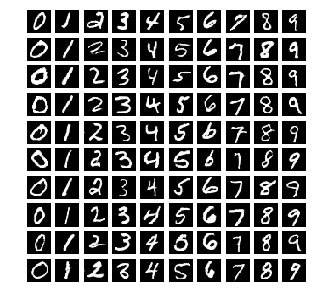

80000 [D loss: 0.285226, acc.: 88.67%] [G loss: 4.845442]


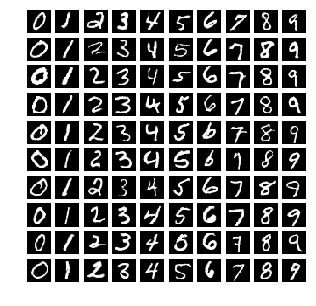

81000 [D loss: 0.094609, acc.: 98.05%] [G loss: 5.902065]


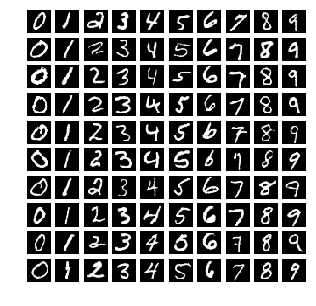

82000 [D loss: 0.108299, acc.: 96.48%] [G loss: 3.764796]


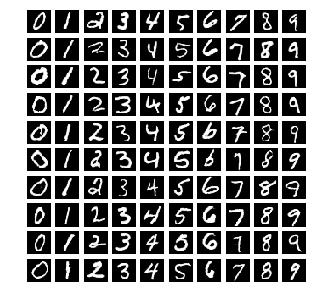

83000 [D loss: 0.153298, acc.: 97.66%] [G loss: 2.270569]


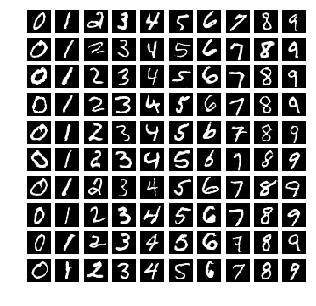

84000 [D loss: 0.258165, acc.: 88.28%] [G loss: 1.827024]


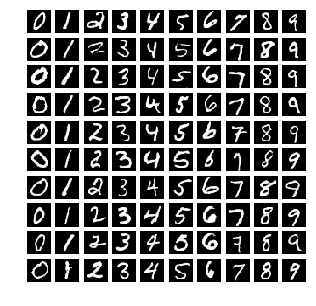

85000 [D loss: 0.052239, acc.: 100.00%] [G loss: 6.151075]


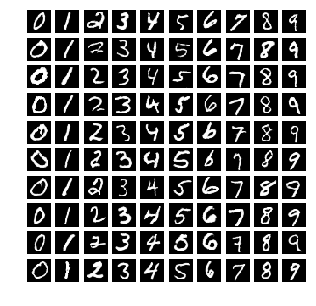

86000 [D loss: 0.059807, acc.: 100.00%] [G loss: 4.125916]


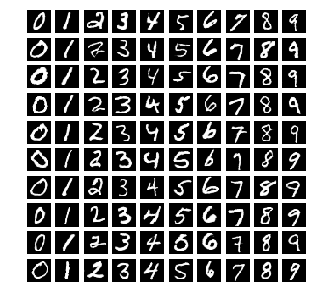

87000 [D loss: 0.105442, acc.: 98.05%] [G loss: 2.329369]


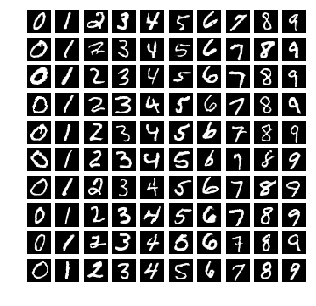

88000 [D loss: 1.103805, acc.: 45.70%] [G loss: 4.018010]


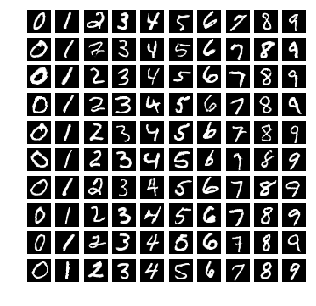

89000 [D loss: 0.401824, acc.: 80.47%] [G loss: 3.437176]


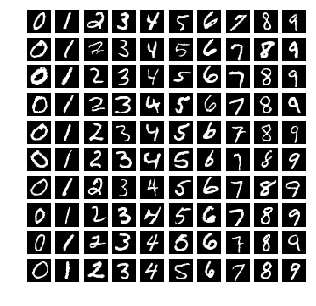

90000 [D loss: 0.569535, acc.: 69.14%] [G loss: 2.865387]


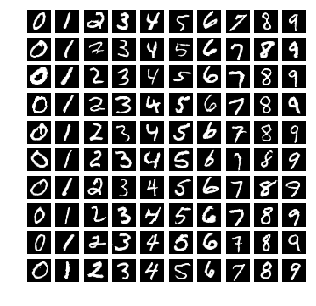

91000 [D loss: 0.088051, acc.: 98.83%] [G loss: 2.349831]


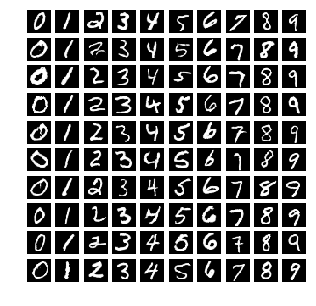

92000 [D loss: 0.430195, acc.: 78.91%] [G loss: 2.365960]


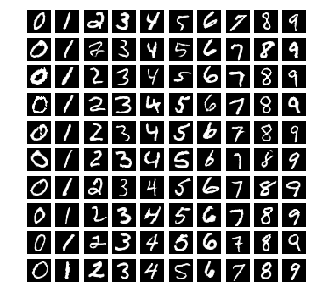

93000 [D loss: 0.566930, acc.: 72.27%] [G loss: 2.926129]


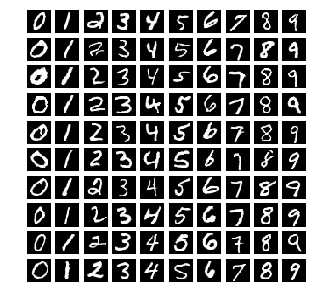

94000 [D loss: 0.075565, acc.: 98.44%] [G loss: 5.735343]


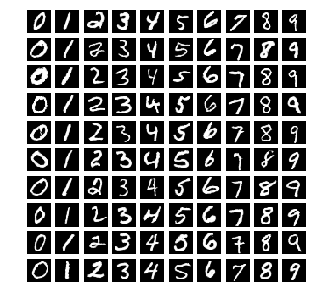

95000 [D loss: 0.164460, acc.: 93.36%] [G loss: 3.752568]


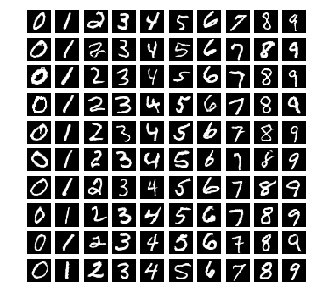

96000 [D loss: 0.165425, acc.: 96.48%] [G loss: 4.401616]


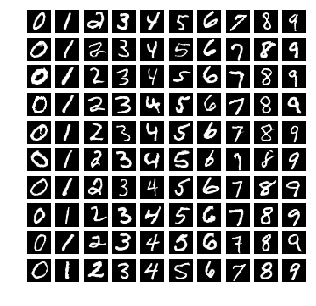

97000 [D loss: 0.029285, acc.: 100.00%] [G loss: 5.327744]


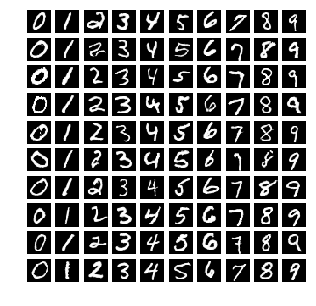

98000 [D loss: 1.039784, acc.: 54.30%] [G loss: 1.713489]


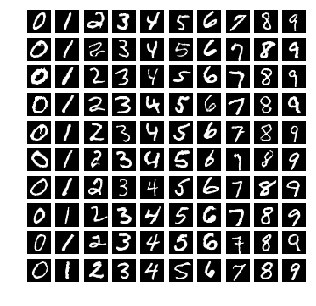

99000 [D loss: 0.222813, acc.: 94.14%] [G loss: 5.201797]


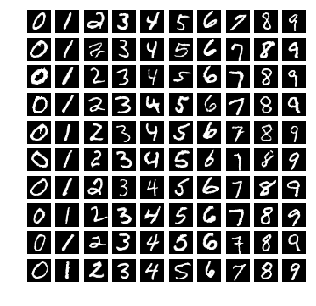

100000 [D loss: 0.193070, acc.: 94.14%] [G loss: 3.008104]


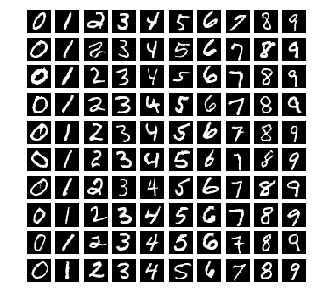

In [0]:
iterations = 100000
batch_size = 128
sample_interval = 1000
train_cgan(generator, discriminator, iterations, batch_size, sample_interval)